### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


In [ ]:
import os

try:
    from petsc4py import PETSc

    import dolfinx

    if not dolfinx.has_petsc:
        print("This demo requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This demo requires petsc4py.")
    exit(0)

from mpi4py import MPI

import numpy as np

import ufl
from basix.ufl import element, mixed_element
from dolfinx import default_real_type, log, plot
from dolfinx.fem import Function, functionspace
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_unit_square
from dolfinx.nls.petsc import NewtonSolver
from ufl import dx, grad, inner

try:
    import pyvista as pv
    import pyvistaqt as pvqt

    have_pyvista = True
    if pv.OFF_SCREEN:
        pv.start_xvfb(wait=0.5)
except ModuleNotFoundError:
    print("pyvista and pyvistaqt are required to visualise the solution")
    have_pyvista = False

lmbda = 1.0e-02  # surface parameter
dt = 5.0e-06  # time step
theta = 0.5  # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicholson

msh = create_unit_square(MPI.COMM_WORLD, 96, 96, CellType.triangle)
P1 = element("Lagrange", msh.basix_cell(), 1, dtype=default_real_type)
ME = functionspace(msh, mixed_element([P1, P1]))

q, v = ufl.TestFunctions(ME)

u = Function(ME)  # current solution
u0 = Function(ME)  # solution from previous converged step

# Split mixed functions
c, mu = ufl.split(u)
c0, mu0 = ufl.split(u0)

# Zero u
u.x.array[:] = 0.0

# Interpolate initial condition
rng = np.random.default_rng(42)
u.sub(0).interpolate(lambda x: 0.63 + 0.02 * (0.5 - rng.random(x.shape[1])))
u.x.scatter_forward()

# Compute the chemical potential df/dc
c = ufl.variable(c)
f = 100 * c**2 * (1 - c) ** 2
dfdc = ufl.diff(f, c)

# mu_(n+theta)
mu_mid = (1.0 - theta) * mu0 + theta * mu

# Weak statement of the equations
F0 = inner(c, q) * dx - inner(c0, q) * dx + dt * inner(grad(mu_mid), grad(q)) * dx
F1 = inner(mu, v) * dx - inner(dfdc, v) * dx - lmbda * inner(grad(c), grad(v)) * dx
F = F0 + F1

# Create nonlinear problem and Newton solver
problem = NonlinearProblem(F, u)
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = np.sqrt(np.finfo(default_real_type).eps) * 1e-2

# We can customize the linear solver used inside the NewtonSolver by
# modifying the PETSc options
ksp = solver.krylov_solver
opts = PETSc.Options()  # type: ignore
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
sys = PETSc.Sys()  # type: ignore
# For factorisation prefer MUMPS, then superlu_dist, then default
use_superlu = PETSc.IntType == np.int64  # or PETSc.ScalarType == np.complex64
if sys.hasExternalPackage("mumps") and not use_superlu:
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
elif sys.hasExternalPackage("superlu_dist"):
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "superlu_dist"
ksp.setFromOptions()

# Output file
file = XDMFFile(MPI.COMM_WORLD, "demo_ch/output.xdmf", "w")
file.write_mesh(msh)

# Step in time
t = 0.0

#  Reduce run time if on test (CI) server
if "CI" in os.environ.keys() or "GITHUB_ACTIONS" in os.environ.keys():
    T = 3 * dt
else:
    T = 50 * dt

# Get the sub-space for c and the corresponding dofs in the mixed space
# vector
V0, dofs = ME.sub(0).collapse()

# Prepare viewer for plotting the solution during the computation
if have_pyvista:
    # Create a VTK 'mesh' with 'nodes' at the function dofs
    topology, cell_types, x = plot.vtk_mesh(V0)
    grid = pv.UnstructuredGrid(topology, cell_types, x)

    # Set output data
    grid.point_data["c"] = u.x.array[dofs].real
    grid.set_active_scalars("c")

    p = pvqt.BackgroundPlotter(title="concentration", auto_update=True)
    p.add_mesh(grid, clim=[0, 1])
    p.view_xy(True)
    p.add_text(f"time: {t}", font_size=12, name="timelabel")

c = u.sub(0)
u0.x.array[:] = u.x.array
while t < T:
    t += dt
    r = solver.solve(u)
    print(f"Step {int(t / dt)}: num iterations: {r[0]}")
    u0.x.array[:] = u.x.array
    file.write_function(c, t)

    # Update the plot window
    if have_pyvista:
        p.add_text(f"time: {t:.2e}", font_size=12, name="timelabel")
        grid.point_data["c"] = u.x.array[dofs].real
        p.app.processEvents()

file.close()

# Update ghost entries and plot
if have_pyvista:
    u.x.scatter_forward()
    grid.point_data["c"] = u.x.array[dofs].real
    screenshot = None
    if pv.OFF_SCREEN:
        screenshot = "c.png"
    pv.plot(grid, show_edges=True, screenshot=screenshot)

pyvista and pyvistaqt are required to visualise the solution
[2024-12-02 07:10:15.686] [info] Extract basic topology: 55296->55296
[2024-12-02 07:10:15.686] [info] Build local dual graph
[2024-12-02 07:10:15.686] [info] Build local part of mesh dual graph (mixed)
[2024-12-02 07:10:15.693] [info] GPS pseudo-diameter:(382) 18241-190
[2024-12-02 07:10:15.694] [info] Create topology (single cell type)
[2024-12-02 07:10:15.694] [info] Create topology (generalised)
[2024-12-02 07:10:15.695] [info] Computing communication graph edges (using NBX algorithm). Number of input edges: 1
[2024-12-02 07:10:15.695] [info] Finished graph edge discovery using NBX algorithm. Number of discovered edges 1
[2024-12-02 07:10:15.699] [info] Compute ghost indices
[2024-12-02 07:10:15.699] [info] Computing communication graph edges (using PCX algorithm). Number of input edges: 0
[2024-12-02 07:10:15.699] [info] Finished graph edge discovery using PCX algorithm. Number of discovered edges 0
[2024-12-02 07:10:15.

NameError: name 'grid' is not defined

In [18]:
L2-error: 5.42e-16
Error_max: 8.88e-16

[2024-12-02 06:43:29.612] [info] Column ghost size increased from 0 to 0


array([ 9.6825    ,  5.07083333, 11.3325    , 21.67833333,  8.91916667,
       13.13916667, 20.03833333, 25.19833333,  8.19583333, 15.10583333,
       18.47833333, 23.39833333, 29.03833333,  7.5125    , 17.2325    ,
       16.99833333, 21.67833333, 27.07833333, 33.19833333,  6.86916667,
       19.51916667, 15.59833333, 20.03833333, 25.19833333, 31.07833333,
       37.67833333,  6.26583333, 21.96583333, 14.27833333, 18.47833333,
       23.39833333, 29.03833333, 35.39833333, 42.47833333,  5.7025    ,
       24.5725    , 13.03833333, 16.99833333, 21.67833333, 27.07833333,
       33.19833333, 40.03833333, 47.59833333,  5.17916667, 27.33916667,
       11.87833333, 15.59833333, 20.03833333, 25.19833333, 31.07833333,
       37.67833333, 44.99833333, 53.03833333,  4.69583333, 30.26583333,
       10.79833333, 14.27833333, 18.47833333, 23.39833333, 29.03833333,
       35.39833333, 42.47833333, 50.27833333, 58.79833333,  2.215     ,
       16.215     ,  5.09916667, 13.03833333, 16.99833333, 21.67

#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial T}{\partial t} - \alpha \nabla  T =Q \  \text{en} \  M=\Omega \times (0,t_f) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega $$
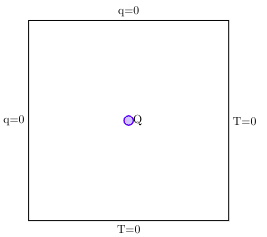

con: 

$$Q=10$$
$$\alpha =0.001$$
## Problema variacional

Encontrar un  $T \ \in \ V$  tal que 
$$
        \int \frac{\partial T}{\partial t}d\Omega +\int \alpha \nabla v \nabla T d\Omega  - \int_{\partial \Omega} \alpha q \cdot n ds - \int Qvd\Omega = 0
$$

## definicion funciones 

In [1]:
from petsc4py import PETSc
from mpi4py import MPI
from basix.ufl import element
from dolfinx import fem, io, plot ,geometry
import dolfinx.mesh as Mesh
from dolfinx.fem.petsc import (
    assemble_vector, 
    assemble_matrix,
    assemble_vector,
    create_vector,
    apply_lifting,
    set_bc
)
from ufl import (
    CellDiameter,
    FacetNormal,
    TestFunction,
    TrialFunction,
    avg,
    jump,
    conditional,
    div,
    dot,
    dS,
    ds,
    dx,
    extract_blocks,
    grad,
    gt,
    inner,
    outer,
    lhs,
    rhs,
)

import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
from matplotlib.legend_handler import HandlerLine2D
#from label_lines import * #graficas 
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import pandas as pd
import sys
import os
from scipy import integrate
from pathlib import Path


np.set_printoptions(formatter={'float': '{: 0.2F}'.format})


start_code = time.time()
def fi (A,m):
    n = A.shape[0]  # Tamaño de la matriz
    e1 = np.zeros((n, 1))  # Crea el primer vector canónico
    e1[0, 0] = 1
    # Añade el vector canónico como nueva columna
    expanded_matrix = np.hstack((A, e1))
    
    # Añade una fila de ceros al final
    zeros_row = np.zeros((1, expanded_matrix.shape[1]))
    expanded_matrix = np.vstack((expanded_matrix, zeros_row))
    
    
    phi = scipy.linalg.expm(expanded_matrix)



    return phi[:-1, -1] , expanded_matrix[:-1, :-1]
# algoritmos de arnoldi

def arnoldi_iteration(A, b,tau,n_old):
    m  = A.size[0]
    
    tol=1E-3
    n_int = n_old -1
    n=n_int
    error=1
    
    H  = np.zeros((n + 1, n))
    
    Q_ = np.zeros((m, n + 1))
    
    beta = b.norm()
    q = b.duplicate()
    q = b.copy()
    q.scale(1 / beta)
    q.assemble()
    j=0
    Q_[:, 0]  =  q.getArray()

    v = PETSc.Vec().createSeq(m)
    column_vec = PETSc.Vec().createSeq(m)
    m_indices = np.arange(m, dtype=np.int32)  # Índices de las filas (todas las filas)
    
    while error >= tol:
        
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            Q_=np.pad(Q_, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_1 = np.zeros(n)
        e_1[0] = 1
        e_m = np.zeros(n)
        e_m[n - 1] = 1
        n_indices = np.arange(n, dtype=np.int32)

        A.mult(q, v)

        for i in range(j + 1):

            column_vec.setValues(m_indices,Q_[:, i])
            column_vec.assemble()

            h_ij = column_vec.dot(v)
            H[i, j] = h_ij
            v.axpy(-h_ij, column_vec)

        v_n = v.norm()
        H[i + 1, j] = v_n
        q = v.copy()
        q.scale(1 / v_n)
        Q_[:, j + 1] =  q.getArray()

        j += 1
        if n>n_int or (n==n_int and j==n_int):

            fi_m, exp_H = fi(H[0:n, 0:n]*tau, n)
            error = beta * abs(H[n,n-1]* tau * e_m.dot(fi_m))
            n += 1
            
    print(f"H dim= {Q_[:,0:n].shape[1]} error = {error}")
    return Q_[:,0:n-1], H[0:n-1, 0:n-1],fi_m,n,exp_H,beta,Q_[:,0:n].shape[1]


def arnoldi_iteration_m(A, b, tau, n):
    print('ar_start')
    m  = A.size[0]

    H  = np.zeros((n + 1, n))
    
    Q_ = np.zeros((m, n + 1))

    e_1 = np.zeros(n)
    e_1[0] = 1
    e_m = np.zeros(n)
    e_m[n - 1] = 1

    beta = b.norm()
    q = b.duplicate()
    q = b.copy()
    q.scale(1 / beta)
    q.assemble()

    m_indices = np.arange(m, dtype=np.int32)  # Índices de las filas (todas las filas)
    n_indices = np.arange(n, dtype=np.int32)

    Q_[:, 0]  =  q.getArray()
    
    v = PETSc.Vec().createSeq(m)
    column_vec = PETSc.Vec().createSeq(m)
    print('ar_loop_start')
    for j in range(n):
        A.mult(q, v)
        
        for i in range(j + 1):

            column_vec.setValues(m_indices,Q_[:, i])
            column_vec.assemble()
            h_ij = column_vec.dot(v)
            H[i, j] = h_ij
            v.axpy(-h_ij, column_vec)
        
        v_n = v.norm()
        H[i + 1, j] = v_n
        q = v.copy()
        q.scale(1 / v_n)
        Q_[:, j + 1] =  q.getArray()
    # Implementar fi y exp_H de acuerdo a tus requisitos
    fi_m, exp_H = fi(H[0:n, 0:n]*tau, n)
    error = beta * abs(H[n,n-1]* tau * e_m.dot(fi_m))
    
    print(f"H dim= {Q_[:,0:n].shape[1]} error = {error}")

    return Q_[:,0:n], H[0:n, 0:n], fi_m,  n, exp_H,beta
    

def exp_form(mesh,flux_method,C_file):
    orden = 1
    V_ele = element("DG", mesh.topology.cell_name(), orden)
    V     = fem.functionspace(mesh, V_ele)
    
    
    u_a   = u_analy()
    u_a.t = 0.0
    
    
    u_0   = fem.Function(V)
    u_0.interpolate(u_a.eval)
    
#_________________________________ Dirichlet Boundary Conditions
    # bc_f   = u_analy_bcs()
    # bc_f.t = 0.0
    u_bc = fem.Function(V)
    u_bc.interpolate(u_a.eval)
    
    dofs_D = fem.locate_dofs_geometrical(V, boundary_D)
    
    bcs = fem.dirichletbc(u_bc , dofs_D)
    
#__________________________________ Varational Formulation    
    
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n = FacetNormal(mesh)
    
    alpha = 1
    
    h = CellDiameter(mesh)
    
    
    if 'LaxF' == flux_method:
        C = w[0]
        flux = dot(avg(w*u),n('+')) + 0.5*C*jump(u)
    elif 'upwind' == flux_method:
        un = (dot(w, n) + abs(dot(w,n)))/2.0
        flux = jump(un*u)
    
    dif_nflux = -k*inner(jump(u,n),avg(grad(v)))*dS \
                - k*inner(avg(grad(u)),jump(v,n))*dS \
                + (alpha)*inner(jump(u,n),jump(v,n))*dS #flujo difusivo
    
    adv_nflux =  dot(jump(v), flux)*dS  #+ dot(v, u_analytical)*ds
    
    F_fem = - dot(grad(v),w*u)*dx + adv_nflux \
            - dot(k*grad(u), grad(v))*dx + dif_nflux \
            - fem.Constant(mesh,PETSc.ScalarType((1.0)))*v*dx
    
    K_fem = lhs(F_fem)
    Q_fem = fem.form(rhs(F_fem))  
    
    C_fem=u*v*dx
    
    
    c = fem.form(C_fem)
    C = assemble_matrix( c )
    C.assemble()
    if orden == 1:
        dof_elem=mesh.ufl_cell().num_edges()
    elif orden == 2:
        dof_elem=mesh.ufl_cell().num_edges()*2
    elif orden == 3:
        dof_elem=mesh.ufl_cell().num_edges()*3 + 1
    
    C.setBlockSizes(dof_elem,dof_elem)
    
    # visualized block matrix 
    #def petsc2array(v):
    #    s=v.getValues(range(0, v.getSize()[0]), range(0,  v.getSize()[1]))
    #    return s
    #plt.spy(petsc2array(C))
    
    C_1_array = C.invertBlockDiagonal() # matriz capacitiva inversa 
    
    # Crear la matriz de PETSc de tamaño total
    
    num_blocks = C_1_array.shape[0]
    matrix_size = C_1_array.shape[1] * num_blocks
    
    C_1 = PETSc.Mat().create()
    C_1.setSizes([matrix_size, matrix_size])
    C_1.setType(PETSc.Mat.Type.AIJ)
    C_1.setUp()
    
    # Asignar cada bloque en la diagonal
    for i in range(num_blocks):
        start = i * dof_elem
        end = start + dof_elem
        C_1.setValues(range(start, end),range(start, end), C_1_array[i])
    
    # Finalizar el ensamblaje de la matriz
    C_1.assemble()
    
    if stage_m:
        print('C invertion finish')
        print('K assemble init')
    #ensamble matriz de rigidez
    k_ = fem.form(K_fem)
    K = assemble_matrix(k_ , bcs = [bcs])
    K.assemble()
    
    
    
    
    K.scale(-1.0)
    if stage_m:
        print('K assemble finish')
    # Multiplicación de C_1 y K
    A = C_1.matMult(K)
    
    return(V,k_,u,v,A,C_1,Q_fem,u_0,[bcs],u_bc)
    
def exp_solver(A,u_i,n,table,auto,m_u,u=0):
    arnoldi_ti=time.time()
    if stage_m:
        print('Arnoldi iteration init')
    if auto:
        V_m,H_m,fi_m,m,exp_H,Beta,m_res  = arnoldi_iteration(A,u_i,real_dt,m_u)
    else:
        V_m,H_m,fi_m,m,exp_H,Beta  = arnoldi_iteration_m(A,u_i,real_dt,m_u)
    arnoldi_t=time.time()-arnoldi_ti
    if stage_m:
        print(f'KSP projection time = {arnoldi_t}')
    solver_ti=time.time()
    if n==0:
        u = real_dt*Beta*np.dot(V_m,fi_m) + u_0.x.array
    else:
        u += real_dt*Beta*np.dot(V_m,fi_m)
    solver_t=time.time() -solver_ti
    table.append([arnoldi_t,solver_t,V_m.shape[1],t])
    return u , m


    
def BDF_form(mesh,pconst,flux_method):
    
    # definición del espacio de funciones
    
    V_ele = element("DG", mesh.topology.cell_name(), 1)
    V     = fem.functionspace(mesh, V_ele)
    #w_ele = element("DG", mesh.basix_cell(), 1, shape=(mesh.geometry.dim))
    #V_w =fem.functionspace(mesh, w_ele)
    
    #w=project(u1, V_w)
    
    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n = FacetNormal(mesh)
    
    u_a   = u_analy()
    u_a.t = 0.0
    
    u_bc = fem.Function(V)
    u_bc.interpolate(u_a.eval)
    
    u_0   = fem.Function(V)
    u_0.interpolate(u_a.eval)
    
    u_n   = fem.Function(V)  # Interpola u_D en el espacio de funciones V
    u_n.interpolate(u_a.eval)
    
    u_nn  = fem.Function(V) 
    u_nn.interpolate(u_a.eval)
    
    u_nnn = fem.Function(V)
    u_nnn.interpolate(u_a.eval)
    
    pconst = BDF_coef[Integrador]
    du     = pconst[0]*u
    du_n   = pconst[1]*u_n
    du_nn  = pconst[2]*u_nn
    du_nnn = pconst[3]*u_nnn
    
    du_t = du+du_n +du_nn +du_nnn
    
    dofs_D = fem.locate_dofs_geometrical(V, boundary_D)
    
# ________________Boundary condition 
    bcs = fem.dirichletbc(u_bc, dofs_D)
    
    alpha=1
    h = CellDiameter(mesh)
    #ds = Measure('ds', domain=mesh, subdomain_data=contorno)
    
    if 'LaxF' == flux_method:
        C = w[0]
        flux = dot(avg(w*u),n('+')) + 0.5*C*jump(u)
    
    elif 'upwind' == flux_method:
        un = (dot(w, n) + abs(dot(w,n)))/2.0
        flux = jump(un*u,n)
    
    dif_nflux = -k*inner(jump(u,n),avg(grad(v)))*dS - k*inner(avg(grad(u)),jump(v,n))*dS \
                + (alpha)*inner(jump(u,n),jump(v,n))*dS #flujo difusivo
    
    adv_nflux =  dot(jump(v,n), flux)*dS  #+ dot(v, u_analytical)*ds
    
    F = du_t*v*dx \
        - real_dt*dot(grad(v), w*u)*dx  + real_dt*adv_nflux \
        + real_dt*dot(k*grad(u), grad(v))*dx +real_dt*dif_nflux \
        - real_dt*fem.Constant(mesh,PETSc.ScalarType((1.0)))*v*dx

    
    # Separa la parte izquierda y derecha del problema variacional  
    
    L = fem.form(lhs(F))
    R = fem.form(rhs(F))  
      
    return(V,L,R,u_n,u_nn,u_nnn,[bcs],u_bc)





### Problema Homogeneo

Number of nodes: 8421
Number of elements: 16000
Number of DOFs: 8421
C invertion finish
K assemble init
K assemble finish
Tiempo de ensamblaje 0.31136059761047363
Arnoldi iteration init
H dim= 58 error = 0.0008230188498496257
KSP projection time = 2.1322503089904785
step:1 of 100 time = 0.1, L2 error = 0.0008678145816573902
Arnoldi iteration init
H dim= 58 error = 0.0007985861451917794
KSP projection time = 2.922382116317749
step:2 of 100 time = 0.2, L2 error = 0.0009155301770933824
Arnoldi iteration init
H dim= 58 error = 0.0006629369405771042
KSP projection time = 2.193091630935669
step:3 of 100 time = 0.30000000000000004, L2 error = 0.0009912768648812247
Arnoldi iteration init
H dim= 58 error = 0.0005504964104434213
KSP projection time = 3.388059616088867
step:4 of 100 time = 0.4, L2 error = 0.0010916407619600069
Arnoldi iteration init
H dim= 58 error = 0.0005094763681923942
KSP projection time = 3.2144694328308105
step:5 of 100 time = 0.5, L2 error = 0.001212355804099276
Arnoldi it

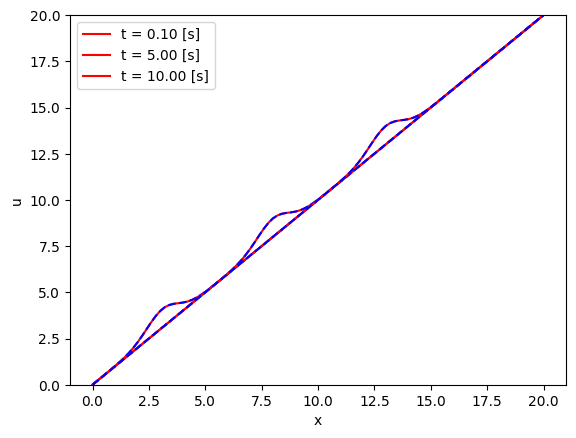

total time = 253.5395848751068


In [3]:
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
start_code = time.time()


ny  = 20 
nx = ny*20

x_start = 0
x_end = 20
mesh = Mesh.create_rectangle(MPI.COMM_WORLD, [np.array([x_start,0 ]), np.array([x_end, 1])],[nx, ny], 
                             Mesh.CellType.triangle,diagonal=Mesh.DiagonalType(1))

Integrador  = "exp"  # time integration method
flux_method = "upwind"
mode_KSP = "auto"
stage_m =True

# Parámetros de simulación
dt = 0.1
T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
k = fem.Constant(mesh,PETSc.ScalarType((0.0001)))
w = fem.Constant(mesh,PETSc.ScalarType((1,0)))


#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
class u_analy:
    def __init__(self):
        self.t = 0.0
    
    def eval(self, x):
        # Added some spatial variation here. Expression 
        return np.full(x.shape[1], 1/(np.sqrt(1+0.0004*self.t))*np.exp(-np.pow((x[0]-3-self.t),2)/(1+0.0004*self.t)) + x[0])
 
def boundary_D(x):
    Left  = np.isclose(x[0], x_start )
    Right = np.isclose(x[0], x_end   )
    Up    = np.isclose(x[1], 1       )
    Down  = np.isclose(x[1], 0       )
    return np.logical_or(np.logical_or(Left, Right), np.logical_or(Down, Up))




f=fem.Constant(mesh,PETSc.ScalarType(0))

#q=Expression('-1',t=0,degree=2) #neumman BC

BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}

# Creación de la malla y definición del espacio de funciones



#contorno = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#left().mark(contorno, 1)
#right().mark(contorno, 2)
print('Number of nodes:', mesh.geometry.x.shape[0] )
print('Number of elements:', mesh.topology.index_map(2).size_local )
print('Number of DOFs:',mesh.geometry.x.shape[0] )

try:
    os.mkdir(f"results_dt_{real_dt}") 
except FileExistsError:
    pass
t= 0
if Integrador == "exp":
    C_file= False#sys.argv[5] == "y"
    assemble_ti=time.time()
    V,L,u_t,v_t,A,C_1,Q_fem,u_0,bcs,u_bc = exp_form(mesh,flux_method,C_file)
    
    u_i = create_vector(Q_fem)
    q_v = fem.form(Q_fem)
    Q_v = create_vector(Q_fem)
    if stage_m:
        print(f"Tiempo de ensamblaje {time.time()- assemble_ti}")
elif (Integrador == "BDF1")or(Integrador == "BDF2") or (Integrador == "BDF3") or (Integrador == "BDF_OP"):
    V,L,R,u_n,u_nn,u_nnn,bcs,u_bc, = BDF_form(mesh,BDF_coef[Integrador],flux_method)
    
    A = assemble_matrix(L, bcs=bcs)
    A.assemble()
    b = create_vector(R)
    solver = PETSc.KSP().create(mesh.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)

    
else: 
    print("esquema de integración temporal erroneo")
    exit()

uh = fem.Function(V)
uh.name = "u"
t=0
u_file = io.VTKFile(mesh.comm, f"resultados_{Integrador}/u.pvd","w")
u_file.write_mesh(mesh)

L2=[]
table =[]
sol=[]

#points for plotting 


tol = 0.001  # Avoid hitting the outside of the domain
x_dot = np.linspace(x_start + tol, x_end - tol, 101)
points = np.zeros((3, 101))
points[0] = x_dot
points[1] = np.full(101, 0)
bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
#________ Solución analitica
u_a = u_analy()
u_a.t = 0
u_analitica = fem.Function(V)
def near(var,value,tol):
    return abs(var-value) < tol  
L2_error=fem.form((uh - u_analitica )**2 * dx)

for n_s in range(num_steps):

    if Integrador == "exp":
        u_a.t += dt
        u_analitica.interpolate(u_a.eval)
        u_bc.interpolate(u_a.eval)
        if mode_KSP == 'auto': 
            with Q_v.localForm() as loc_Q_v:
                loc_Q_v.set(0)
            
            assemble_vector(Q_v , Q_fem)
            apply_lifting(Q_v, [L], [bcs])
            Q_v.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
            
            set_bc(Q_v, bcs)

            Q = create_vector(Q_fem)
            C_1.mult(Q_v,Q) 

            
            if n_s ==0:
                A.multAdd(u_0.x.petsc_vec,Q,u_i)
                #A.mult(u_0.x.petsc_vec , u_i)
                u,m_u =exp_solver(A,u_i,n_s,table,True,20)
            else:
                A.multAdd(uh.x.petsc_vec,Q,u_i)
                #A.mult(uh.x.petsc_vec , u_i)
                u,m_u =exp_solver(A,u_i,n_s,table,True,m_u,u)
        else: 
            m_u = int(mode_KSP)
            Q=Q_t(Q_fem,C_1,bcs)
            if n_s ==0:
                A.multAdd(u_0.x.petsc_vec,Q,u_i)
                #A.mult(u_0.x.petsc_vec , u_i)
                u,H_m =exp_solver(A,u_i,n_s,table,False,m_u)
            else:
                A.multAdd(uh.x.petsc_vec,Q,u_i)
                #A.mult(uh.x.petsc_vec , u_i)
                u =exp_solver(A,u_i,n_s,table,False,m_u,u)
        uh.x.array[:] =u

    elif (Integrador == "BDF1")or(Integrador == "BDF2") or (Integrador == "BDF3") or (Integrador == "BDF_OP"):
        with b.localForm() as loc_b:
                loc_b.set(0)
        assemble_vector(b , R)
    
        # Apply Dirichlet boundary condition to the vector
        apply_lifting(b, [L], [bcs])
        b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, bcs)
    
        # Solve linear problem
        solver.solve(b, uh.x.petsc_vec)
        uh.x.scatter_forward()
    
        # Update solution at previous time step (u_n)
        u_nnn.x.array[:] = u_nn.x.array
        u_nn.x.array[:] = u_n.x.array
        u_n.x.array[:] = uh.x.array
        
        u_a.t += dt
        u_analitica.interpolate(u_a.eval)
        u_bc.interpolate(u_a.eval)

    
    u_file.write_function(uh,t)
    u_file.close()
    t += real_dt
    
    u_an = []
    u_p = []
    u_p = uh.eval(points_on_proc, cells)
    u_an = u_analitica.eval(points_on_proc,cells)
    if near(t,real_dt,real_dt/2) or near(t,5,real_dt/2) or near(t,10,real_dt/2):
        if near(t,real_dt,real_dt/2):
            plt.plot(points_on_proc[:, 0],u_p,'r-',label=f't = {t:.2f} [s]')
        elif near(t,5,real_dt/2):
            plt.plot(points_on_proc[:, 0],u_p,'r-',label=f't = {t:.2f} [s]')
        elif near(t,10,real_dt/2):
            plt.plot(points_on_proc[:, 0],u_p,'r-',label=f't = {t:.2f} [s]')
        plt.plot(points_on_proc[:, 0],u_an,'b--')
       
    L2_norm=np.sqrt(mesh.comm.allreduce(fem.assemble_scalar(L2_error), op=MPI.SUM))
    L2.append([L2_norm,t])
    print(f'step:{n_s+1} of {num_steps} time = {t}, L2 error = {L2_norm}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.ylim(0,20)
    plt.legend(loc='upper left')
plt.show()

print(f"total time = {time.time() - start_code}")

In [82]:
bcs[0].set

<bound method DirichletBC.set of <dolfinx.fem.bcs.DirichletBC object at 0x7636cd19e7b0>>

# Test

In [31]:




for n_s in range(num_steps):
    # Update Diriclet boundary condition
    t += dt
    print (f'time : {t} step : {n_s}' )
    u_a.t += dt
    u_analytical.interpolate(u_a.eval )

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, L)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [a], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_nnn.x.array[:] = u_nn.x.array
    u_nn.x.array[:] = u_n.x.array
    u_n.x.array[:] = uh.x.array
    if n_s%2 == 0 :
        u_file.write_function(uh,t)
    
        #plot
        u_values = []
        p_values = []
        
        u_values = uh.eval(points_on_proc, cells)
        import matplotlib.pyplot as plt
        fig = plt.figure()
        plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2, label="u value")
        plt.grid(True)
        plt.xlabel("x")
        plt.legend()
        plt.xlim(0,10)
        plt.ylim(0,1)
        plt.show()

print(f"total time = {time.time() - start_code}")

2000

time : 1 step : 0


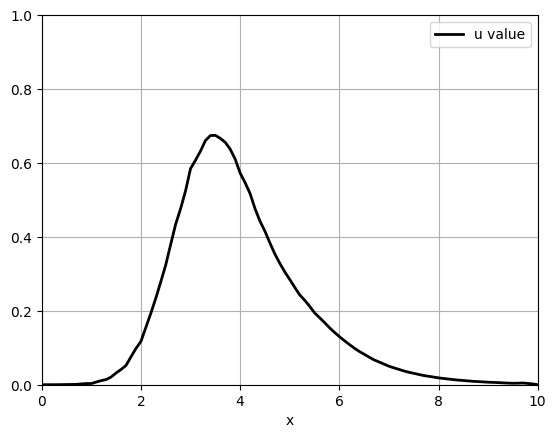

time : 2 step : 1
time : 3 step : 2


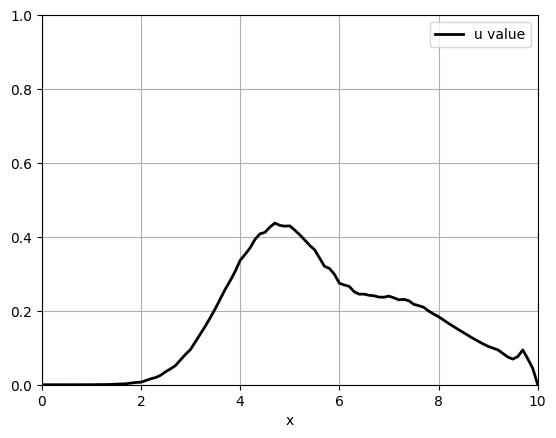

time : 4 step : 3
time : 5 step : 4


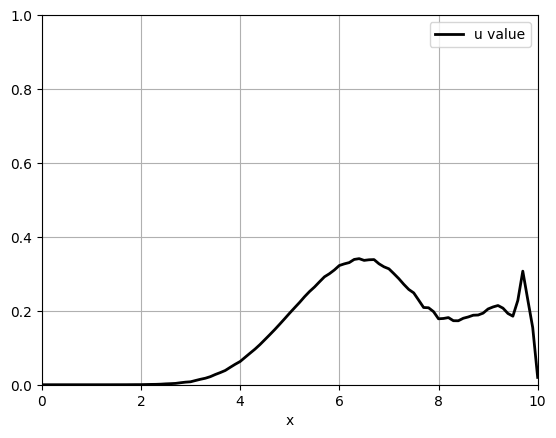

time : 6 step : 5
time : 7 step : 6


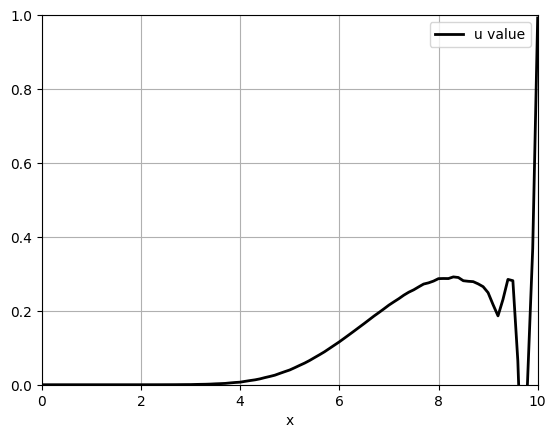

time : 8 step : 7
time : 9 step : 8


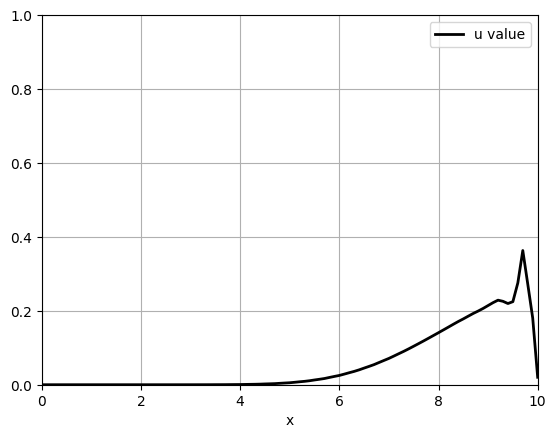

time : 10 step : 9
total time = 1.2026660442352295


In [5]:
from petsc4py import PETSc
from mpi4py import MPI
from basix.ufl import element
from dolfinx import fem, io, plot ,geometry
import dolfinx.mesh as Mesh
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from ufl import (
    CellDiameter,
    FacetNormal,
    TestFunction,
    TrialFunction,
    jump,
    avg,
    conditional,
    div,
    dot,
    dS,
    ds,
    dx,
    extract_blocks,
    grad,
    gt,
    inner,
    outer,
    lhs,
    rhs,
)


import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
from matplotlib.legend_handler import HandlerLine2D
from label_lines import * #graficas 
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import pandas as pd
import sys
import os
from scipy import integrate
from pathlib import Path
start_code = time.time()
ny  = 3 
nx = ny*10

start = 0
x_end = 10
mesh = Mesh.create_rectangle(MPI.COMM_WORLD, [np.array([start,0 ]), np.array([x_end, 1])],[nx, ny], Mesh.CellType.triangle)

solver  = "BDF1"  # time integration method
flux_method = "upwind"
mode_KSP = "40"
stage_m =False

# Parámetros de simulación
dt = 1
T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
k = fem.Constant(mesh,PETSc.ScalarType((0.0001)))
w = fem.Constant(mesh,PETSc.ScalarType((1,0)))



#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
class u_analy:
    def __init__(self):
        self.t = 0.0

    def eval(self, x):
        # Added some spatial variation here. Expression is sin(t)*x
        return np.full(x.shape[1], 1/(np.sqrt(1+0.0004*self.t))*np.exp(-np.pow((x[0]-3-self.t),2)/(1+0.0004*self.t)))
        
class u_analy_bcs:
    def __init__(self):
        self.t = 0.0

    def eval(self, x):
        # Added some spatial variation here. Expression is sin(t)*x
        return np.full(x.shape[1], -1/(np.sqrt(1+0.0004*self.t))*np.exp(-np.pow((x[0]-3-self.t),2)/(1+0.0004*self.t)))





f=fem.Constant(mesh,PETSc.ScalarType(0))

#q=Expression('-1',t=0,degree=2) #neumman BC

BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}
pconst=BDF_coef[solver]
# Creación de la malla y definición del espacio de funciones






V_ele=element("DG", mesh.topology.cell_name(), 1)
#w_ele = element("DG", mesh.basix_cell(), 1, shape=(mesh.geometry.dim))
#V_w =fem.functionspace(mesh, w_ele)
V =fem.functionspace(mesh, V_ele)
#w=project(u1, V_w)
# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n = FacetNormal(mesh)

u_a =  u_analy()
u_a.t = 0.0
u_0 = fem.Function(V)
u_0.interpolate(u_a.eval)

u_a = u_analy()

u_analytical = fem.Function(V)

u_a.t = 0
u_analytical.interpolate(u_a.eval)


u_n = fem.Function(V)  # Interpola u_D en el espacio de funciones V
u_n.interpolate(u_a.eval)

u_nn = fem.Function(V) 
u_nn.interpolate(u_a.eval)

u_nnn = fem.Function(V)
u_nnn.interpolate(u_a.eval)


du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn

def boundary_D(x):
    return np.logical_or(np.logical_or(np.isclose(x[0], start ), np.isclose(x[0], x_end)), np.logical_or(np.isclose(x[1], 0 ), np.isclose(x[1], 1)))


dofs_D = fem.locate_dofs_geometrical(V, boundary_D)

bc = fem.dirichletbc(u_analytical, dofs_D)


alpha=1
h = CellDiameter(mesh)
#ds = Measure('ds', domain=mesh, subdomain_data=contorno)

if 'LaxF' == flux_method:
    C = w[0]
    flux = dot(avg(w*u),n('+')) + 0.5*C*jump(u)
elif 'upwind' == flux_method:
    un = (dot(w, n) + abs(dot(w,n)))/2.0
    flux = jump(un*u,n)

dif_nflux = -k*inner(jump(u,n),avg(grad(v)))*dS - k*inner(avg(grad(u)),jump(v,n))*dS \
            + (alpha)*inner(jump(u,n),jump(v,n))*dS #flujo difusivo

adv_nflux =  dot(jump(v,n), flux)*dS  #+ dot(v, u_analytical)*ds

#F = du_t*v*dx - real_dt*dot(grad(v),w*u)*dx + real_dt*adv_nflux - real_dt*dot(k*grad(u), grad(v))*dx + real_dt*dif_nflux

F = du_t*v*dx - real_dt*dot(grad(v), w*u)*dx - real_dt*dot(k*grad(u), grad(v))*dx
#F += real_dt*dot(jump(v), flux)*dS + real_dt*dot(v, u_analytical*u)*ds
F +=  real_dt*dif_nflux + real_dt*adv_nflux 
a = fem.form(lhs(F))
L = fem.form(rhs(F))
A = assemble_matrix(a, bcs=[bc])
A.assemble()
b = create_vector(L)

solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

t = 0

uh = fem.Function(V)
uh.name = "u"
uh.interpolate(u_a.eval)
u_file = io.VTKFile(mesh.comm, "resultsdx/u.pvd","w")
u_file.write_mesh(mesh)

tol = 0.001  # Avoid hitting the outside of the domain
x = np.linspace(start + tol, x_end - tol, 101)
points = np.zeros((3, 101))
points[0] = x
points[1] = np.full(101, 0.5)
bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
for n_s in range(num_steps):
    # Update Diriclet boundary condition
    t += dt
    print (f'time : {t} step : {n_s}' )
    u_a.t += dt
    u_analytical.interpolate(u_a.eval )

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, L)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [a], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_nnn.x.array[:] = u_nn.x.array
    u_nn.x.array[:] = u_n.x.array
    u_n.x.array[:] = uh.x.array
    if n_s%2 == 0 :
        u_file.write_function(uh,t)
    
        #plot
        u_values = []
        p_values = []
        
        u_values = uh.eval(points_on_proc, cells)
        import matplotlib.pyplot as plt
        fig = plt.figure()
        plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2, label="u value")
        plt.grid(True)
        plt.xlabel("x")
        plt.legend()
        plt.xlim(0,10)
        plt.ylim(0,1)
        plt.show()

print(f"total time = {time.time() - start_code}")

# Exp

<empty Form>
C invertion finish
K assemble init
time : 0.1 step : 0
Arnoldi iteration init
n dim 19 error 2.2856474040497208e-07
H dim= 20 error = 2.2856474040497208e-07
KSP projection time = 0.018294095993041992


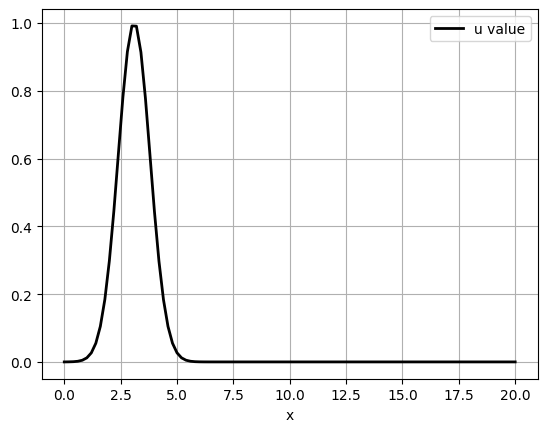

time : 0.2 step : 1
Arnoldi iteration init
n dim 19 error 1.3707668304933863e-09
H dim= 20 error = 1.3707668304933863e-09
KSP projection time = 0.012407541275024414
time : 0.30000000000000004 step : 2
Arnoldi iteration init
n dim 19 error 2.3267614349126082e-11
H dim= 20 error = 2.3267614349126082e-11
KSP projection time = 0.012527942657470703
time : 0.4 step : 3
Arnoldi iteration init
n dim 19 error 1.104710198813523e-12
H dim= 20 error = 1.104710198813523e-12
KSP projection time = 0.03373908996582031
time : 0.5 step : 4
Arnoldi iteration init
n dim 19 error 8.18944890206182e-14
H dim= 20 error = 8.18944890206182e-14
KSP projection time = 0.046277523040771484
time : 0.6 step : 5
Arnoldi iteration init
n dim 19 error 4.0382575412116586e-14
H dim= 20 error = 4.0382575412116586e-14
KSP projection time = 0.019243240356445312
time : 0.7 step : 6
Arnoldi iteration init
n dim 19 error 7.453409747289404e-14
H dim= 20 error = 7.453409747289404e-14
KSP projection time = 0.01607370376586914
time

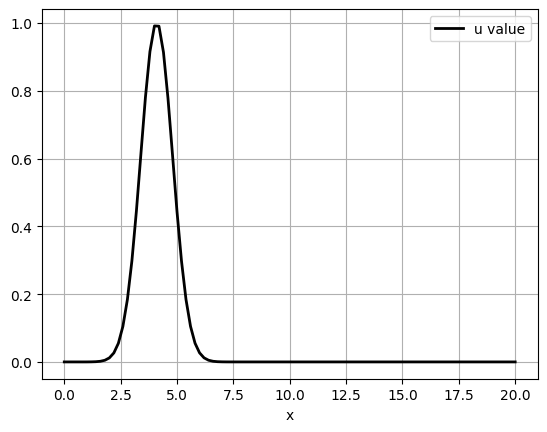

time : 1.2 step : 11
Arnoldi iteration init
n dim 19 error 2.566469761703368e-15
H dim= 20 error = 2.566469761703368e-15
KSP projection time = 0.012810707092285156
time : 1.3 step : 12
Arnoldi iteration init
n dim 19 error 0.0
H dim= 20 error = 0.0
KSP projection time = 0.013248920440673828
time : 1.4000000000000001 step : 13
Arnoldi iteration init
n dim 19 error 0.0
H dim= 20 error = 0.0
KSP projection time = 0.012457132339477539
time : 1.5000000000000002 step : 14
Arnoldi iteration init
n dim 19 error 0.0
H dim= 20 error = 0.0
KSP projection time = 0.04279923439025879
time : 1.6000000000000003 step : 15
Arnoldi iteration init
n dim 19 error 0.0
H dim= 20 error = 0.0
KSP projection time = 0.019105911254882812
time : 1.7000000000000004 step : 16
Arnoldi iteration init
n dim 19 error 1.6970139107099785e-14
H dim= 20 error = 1.6970139107099785e-14
KSP projection time = 0.01210641860961914
time : 1.8000000000000005 step : 17
Arnoldi iteration init
n dim 19 error 2.0946465324035917e-14
H d

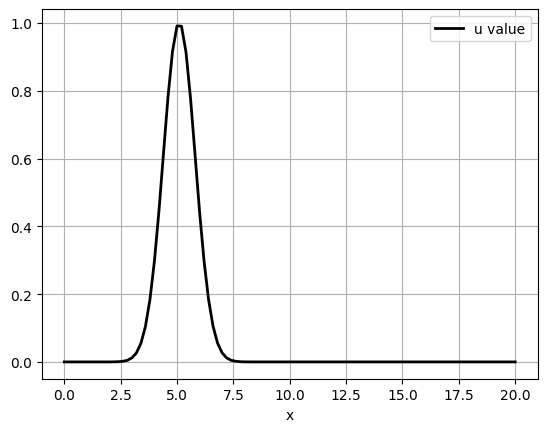

time : 2.2000000000000006 step : 21
Arnoldi iteration init
n dim 19 error 1.9144251958951862e-14
H dim= 20 error = 1.9144251958951862e-14
KSP projection time = 0.010447502136230469
time : 2.3000000000000007 step : 22
Arnoldi iteration init
n dim 19 error 3.2917572756423053e-15
H dim= 20 error = 3.2917572756423053e-15
KSP projection time = 0.01302790641784668
time : 2.400000000000001 step : 23
Arnoldi iteration init
n dim 19 error 3.876669583983805e-14
H dim= 20 error = 3.876669583983805e-14
KSP projection time = 0.012301445007324219
time : 2.500000000000001 step : 24
Arnoldi iteration init
n dim 19 error 2.156825568978493e-14
H dim= 20 error = 2.156825568978493e-14
KSP projection time = 0.015518903732299805
time : 2.600000000000001 step : 25
Arnoldi iteration init
n dim 19 error 3.471454492805495e-14
H dim= 20 error = 3.471454492805495e-14
KSP projection time = 0.011898994445800781
time : 2.700000000000001 step : 26
Arnoldi iteration init
n dim 19 error 2.556734527603391e-14
H dim= 20 

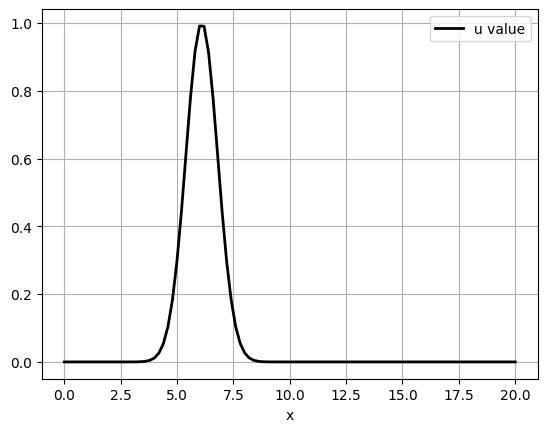

time : 3.2000000000000015 step : 31
Arnoldi iteration init
n dim 19 error 3.263240117484783e-14
H dim= 20 error = 3.263240117484783e-14
KSP projection time = 0.010378360748291016
time : 3.3000000000000016 step : 32
Arnoldi iteration init
n dim 19 error 2.7275315764612926e-14
H dim= 20 error = 2.7275315764612926e-14
KSP projection time = 0.010741710662841797
time : 3.4000000000000017 step : 33
Arnoldi iteration init
n dim 19 error 6.582012826522774e-15
H dim= 20 error = 6.582012826522774e-15
KSP projection time = 0.013797283172607422
time : 3.5000000000000018 step : 34
Arnoldi iteration init
n dim 19 error 1.3175547030047995e-14
H dim= 20 error = 1.3175547030047995e-14
KSP projection time = 0.008705854415893555
time : 3.600000000000002 step : 35
Arnoldi iteration init
n dim 19 error 2.6556920068546205e-14
H dim= 20 error = 2.6556920068546205e-14
KSP projection time = 0.009783744812011719
time : 3.700000000000002 step : 36
Arnoldi iteration init
n dim 19 error 1.3235385926988698e-14
H di

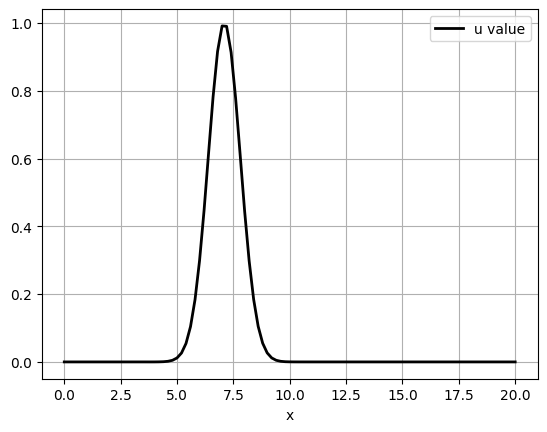

time : 4.200000000000001 step : 41
Arnoldi iteration init
n dim 19 error 1.919512468654421e-13
H dim= 20 error = 1.919512468654421e-13
KSP projection time = 0.019498109817504883
time : 4.300000000000001 step : 42
Arnoldi iteration init
n dim 19 error 4.093872562040102e-14
H dim= 20 error = 4.093872562040102e-14
KSP projection time = 0.011130094528198242
time : 4.4 step : 43
Arnoldi iteration init
n dim 19 error 4.4322174153837617e-13
H dim= 20 error = 4.4322174153837617e-13
KSP projection time = 0.016295433044433594
time : 4.5 step : 44
Arnoldi iteration init
n dim 19 error 7.929230933328308e-14
H dim= 20 error = 7.929230933328308e-14
KSP projection time = 0.023458480834960938
time : 4.6 step : 45
Arnoldi iteration init
n dim 19 error 2.494830028544924e-13
H dim= 20 error = 2.494830028544924e-13
KSP projection time = 0.0325472354888916
time : 4.699999999999999 step : 46
Arnoldi iteration init
n dim 19 error 1.0323128283263067e-13
H dim= 20 error = 1.0323128283263067e-13
KSP projection 

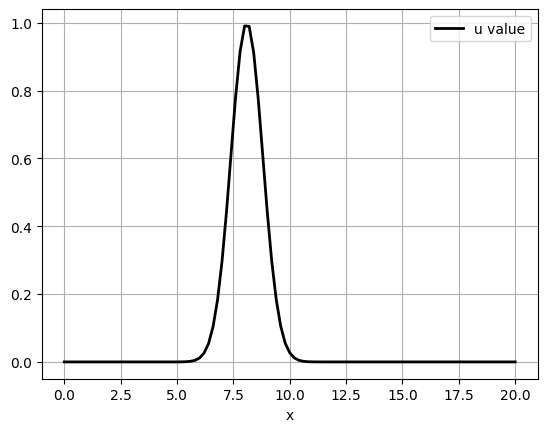

time : 5.1999999999999975 step : 51
Arnoldi iteration init
n dim 19 error 1.681924562425992e-13
H dim= 20 error = 1.681924562425992e-13
KSP projection time = 0.00962519645690918
time : 5.299999999999997 step : 52
Arnoldi iteration init
n dim 19 error 4.668507901186997e-13
H dim= 20 error = 4.668507901186997e-13
KSP projection time = 0.013215303421020508
time : 5.399999999999997 step : 53
Arnoldi iteration init
n dim 19 error 8.874198647650002e-14
H dim= 20 error = 8.874198647650002e-14
KSP projection time = 0.011701822280883789
time : 5.4999999999999964 step : 54
Arnoldi iteration init
n dim 19 error 5.214649621538165e-13
H dim= 20 error = 5.214649621538165e-13
KSP projection time = 0.014620780944824219
time : 5.599999999999996 step : 55
Arnoldi iteration init
n dim 19 error 1.9159384148281557e-13
H dim= 20 error = 1.9159384148281557e-13
KSP projection time = 0.0189211368560791
time : 5.699999999999996 step : 56
Arnoldi iteration init
n dim 19 error 3.912732144363228e-13
H dim= 20 erro

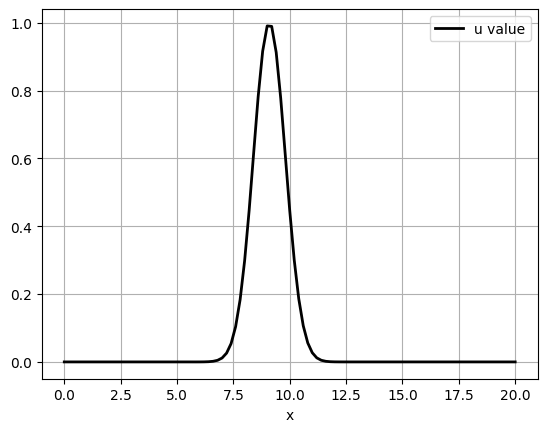

time : 6.199999999999994 step : 61
Arnoldi iteration init
n dim 19 error 5.656909095784545e-14
H dim= 20 error = 5.656909095784545e-14
KSP projection time = 0.009516477584838867
time : 6.299999999999994 step : 62
Arnoldi iteration init
n dim 19 error 1.2700559716899976e-13
H dim= 20 error = 1.2700559716899976e-13
KSP projection time = 0.010863065719604492
time : 6.399999999999993 step : 63
Arnoldi iteration init
n dim 19 error 2.600759012553102e-13
H dim= 20 error = 2.600759012553102e-13
KSP projection time = 0.015257120132446289
time : 6.499999999999993 step : 64
Arnoldi iteration init
n dim 19 error 2.6642617041793914e-13
H dim= 20 error = 2.6642617041793914e-13
KSP projection time = 0.018027067184448242
time : 6.5999999999999925 step : 65
Arnoldi iteration init
n dim 19 error 5.175552376818835e-13
H dim= 20 error = 5.175552376818835e-13
KSP projection time = 0.014911890029907227
time : 6.699999999999992 step : 66
Arnoldi iteration init
n dim 19 error 1.0956585452020089e-13
H dim= 20

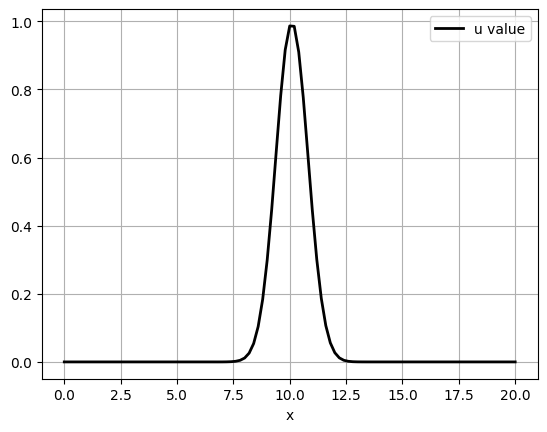

time : 7.19999999999999 step : 71
Arnoldi iteration init
n dim 19 error 1.213121518870239e-13
H dim= 20 error = 1.213121518870239e-13
KSP projection time = 0.019275903701782227
time : 7.29999999999999 step : 72
Arnoldi iteration init
n dim 19 error 1.1387926727124335e-13
H dim= 20 error = 1.1387926727124335e-13
KSP projection time = 0.017203807830810547
time : 7.39999999999999 step : 73
Arnoldi iteration init
n dim 19 error 4.076496785010338e-13
H dim= 20 error = 4.076496785010338e-13
KSP projection time = 0.029835939407348633
time : 7.499999999999989 step : 74
Arnoldi iteration init
n dim 19 error 1.1983419861447612e-13
H dim= 20 error = 1.1983419861447612e-13
KSP projection time = 0.02907109260559082
time : 7.599999999999989 step : 75
Arnoldi iteration init
n dim 19 error 4.859734866876087e-14
H dim= 20 error = 4.859734866876087e-14
KSP projection time = 0.051259756088256836
time : 7.699999999999989 step : 76
Arnoldi iteration init
n dim 19 error 5.999637557920173e-14
H dim= 20 error

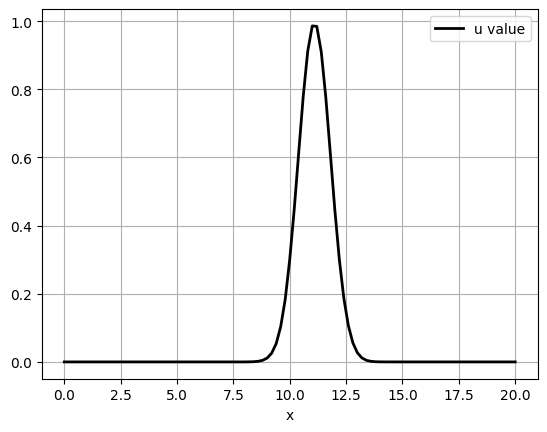

time : 8.199999999999987 step : 81
Arnoldi iteration init
n dim 19 error 2.5857867874552934e-13
H dim= 20 error = 2.5857867874552934e-13
KSP projection time = 0.02162933349609375
time : 8.299999999999986 step : 82
Arnoldi iteration init
n dim 19 error 2.374000113850342e-13
H dim= 20 error = 2.374000113850342e-13
KSP projection time = 0.023598194122314453
time : 8.399999999999986 step : 83
Arnoldi iteration init
n dim 19 error 3.8531439972932465e-13
H dim= 20 error = 3.8531439972932465e-13
KSP projection time = 0.02568674087524414
time : 8.499999999999986 step : 84
Arnoldi iteration init
n dim 19 error 3.248297841389019e-13
H dim= 20 error = 3.248297841389019e-13
KSP projection time = 0.01839280128479004
time : 8.599999999999985 step : 85
Arnoldi iteration init
n dim 19 error 6.200023084046777e-14
H dim= 20 error = 6.200023084046777e-14
KSP projection time = 0.0451970100402832
time : 8.699999999999985 step : 86
Arnoldi iteration init
n dim 19 error 2.740656274404227e-13
H dim= 20 error 

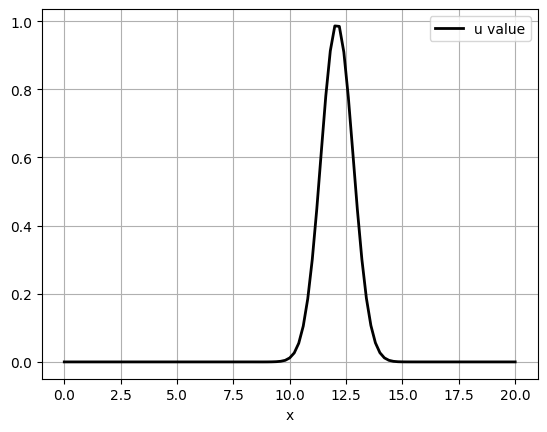

time : 9.199999999999983 step : 91
Arnoldi iteration init
n dim 19 error 2.2361290387513316e-14
H dim= 20 error = 2.2361290387513316e-14
KSP projection time = 0.011710882186889648
time : 9.299999999999983 step : 92
Arnoldi iteration init
n dim 19 error 7.223519302984177e-14
H dim= 20 error = 7.223519302984177e-14
KSP projection time = 0.010598897933959961
time : 9.399999999999983 step : 93
Arnoldi iteration init
n dim 19 error 1.1378504218912415e-13
H dim= 20 error = 1.1378504218912415e-13
KSP projection time = 0.010399341583251953
time : 9.499999999999982 step : 94
Arnoldi iteration init
n dim 19 error 6.385017998399828e-14
H dim= 20 error = 6.385017998399828e-14
KSP projection time = 0.013090133666992188
time : 9.599999999999982 step : 95
Arnoldi iteration init
n dim 19 error 1.2787891549213322e-13
H dim= 20 error = 1.2787891549213322e-13
KSP projection time = 0.019179344177246094
time : 9.699999999999982 step : 96
Arnoldi iteration init
n dim 19 error 5.760925216764772e-13
H dim= 20

In [1]:
from petsc4py import PETSc
from mpi4py import MPI
from basix.ufl import element
from dolfinx import fem, io, plot ,geometry
import dolfinx.mesh as Mesh
from dolfinx.fem.petsc import assemble_vector, assemble_matrix,assemble_vector, create_vector, apply_lifting, set_bc
from ufl import (
    CellDiameter,
    FacetNormal,
    TestFunction,
    TrialFunction,
    avg,
    jump,
    conditional,
    div,
    dot,
    dS,
    ds,
    dx,
    extract_blocks,
    grad,
    gt,
    inner,
    outer,
    lhs,
    rhs,
)


import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
from matplotlib.legend_handler import HandlerLine2D
from label_lines import * #graficas 
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import pandas as pd
import sys
import os
from scipy import integrate
from pathlib import Path

np.set_printoptions(formatter={'float': '{: 0.3F}'.format})

start_code = time.time()

def boundary_D(x):
    return np.logical_or(np.logical_or(np.isclose(x[0], start ), np.isclose(x[0], x_end)), np.logical_or(np.isclose(x[1], 0 ), np.isclose(x[1], 1)))


ny  = 5 
nx = ny*20

x_start = 0
x_end = 20
mesh = Mesh.create_rectangle(MPI.COMM_WORLD, [np.array([x_start,0 ]), np.array([x_end, 1])],[nx, ny], 
                             Mesh.CellType.triangle,diagonal=Mesh.DiagonalType(1))

solver  = "exp"  # time integration method
flux_method = "upwind"
mode_KSP = "auto"
stage_m =True

# Parámetros de simulación
dt = 0.1
T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
k=fem.Constant(mesh,PETSc.ScalarType((0.0001)))
w=fem.Constant(mesh,PETSc.ScalarType((1,0)))



#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
class u_analy:
    def __init__(self):
        self.t = 0.0

    def eval(self, x):
        # Added some spatial variation here. Expression is sin(t)*x
        return np.full(x.shape[1], 1/(np.sqrt(1+0.0004*self.t))*np.exp(-np.pow((x[0]-3-self.t),2)/(1+0.0004*self.t)))
        
class u_analy_bcs:
    def __init__(self):
        self.t = 0.0

    def eval(self, x):
        # Added some spatial variation here. Expression is sin(t)*x
        return np.full(x.shape[1], -1/(np.sqrt(1+0.0004*self.t))*np.exp(-np.pow((x[0]-3-self.t),2)/(1+0.0004*self.t)))





f=fem.Constant(mesh,PETSc.ScalarType(0))

#q=Expression('-1',t=0,degree=2) #neumman BC

#BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}
#pconst=BDF_coef[solver]
# Creación de la malla y definición del espacio de funciones




orden =1

V_ele=element("DG", mesh.topology.cell_name(), orden)
#w_ele = element("DG", mesh.basix_cell(), 1, shape=(mesh.geometry.dim))
#V_w =fem.functionspace(mesh, w_ele)
V =fem.functionspace(mesh, V_ele)
#w=project(u1, V_w)
# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n = FacetNormal(mesh)

u_a =  u_analy()
u_a.t = 0.0
u_0 = fem.Function(V)
u_0.interpolate(u_a.eval)



u_analytical = fem.Function(V)
u_analytical.interpolate(u_a.eval)

def boundary_D(x):
    return np.logical_or(np.logical_or(np.isclose(x[0], x_start ), np.isclose(x[0], x_end)), np.logical_or(np.isclose(x[1], 0 ), np.isclose(x[1], 1)))


dofs_D = fem.locate_dofs_geometrical(V, boundary_D)
u_bc = fem.Function(V)
u_bc.interpolate(u_a.eval)
bc = fem.dirichletbc(u_bc, dofs_D)



alpha=1
h = CellDiameter(mesh)
#ds = Measure('ds', domain=mesh, subdomain_data=contorno)

if 'LaxF' == flux_method:
    C = w[0]
    flux = dot(avg(w*u),n('+')) + 0.5*C*jump(u)
elif 'upwind' == flux_method:
    un = (dot(w, n) + abs(dot(w,n)))/2.0
    flux = jump(un*u)

dif_nflux = -k*inner(jump(u,n),avg(grad(v)))*dS - k*inner(avg(grad(u)),jump(v,n))*dS \
            + (alpha)*inner(jump(u,n),jump(v,n))*dS #flujo difusivo

adv_nflux =  dot(jump(v), flux)*dS  #+ dot(v, u_analytical)*ds

    


F_fem = - dot(grad(v),w*u)*dx + adv_nflux - dot(k*grad(u), grad(v))*dx + dif_nflux

K_fem = lhs(F_fem)
Q_fem = rhs(F_fem) 
print(Q_fem)
C_fem=u*v*dx


c = fem.form(C_fem)
C = assemble_matrix(c)
C.assemble()
if orden == 1:
    dof_elem=mesh.ufl_cell().num_edges()
elif orden == 2:
    dof_elem=mesh.ufl_cell().num_edges()*2
elif orden == 3:
    dof_elem=mesh.ufl_cell().num_edges()*3 + 1

C.setBlockSizes(dof_elem,dof_elem)
# visualized block matrix 
#def petsc2array(v):
#    s=v.getValues(range(0, v.getSize()[0]), range(0,  v.getSize()[1]))
#    return s
#plt.spy(petsc2array(C))

C_1_array = C.invertBlockDiagonal()

# Crear la matriz de PETSc de tamaño total
num_blocks = C_1_array.shape[0]
matrix_size = C_1_array.shape[1] * num_blocks

C_1 = PETSc.Mat().create()
C_1.setSizes([matrix_size, matrix_size])
C_1.setType(PETSc.Mat.Type.AIJ)
C_1.setUp()

# Asignar cada bloque en la diagonal
for i in range(num_blocks):
    start = i * dof_elem
    end = start + dof_elem
    C_1.setValues(range(start, end),range(start, end), C_1_array[i])

# Finalizar el ensamblaje de la matriz
C_1.assemble()

if stage_m:
    print('C invertion finish')
    print('K assemble init')
#ensamble matriz de rigidez
k = fem.form(K_fem)
K = assemble_matrix(k)



K.assemble()
K.scale(-1.0)
# Multiplicación de C_1 y K
A = C_1.matMult(K)

def fi (A,m,tau=1):
    d = scipy.sparse.identity(m)
    exp_A = scipy.linalg.expm(tau*A)
    A_1 = spsl.spsolve(tau*A,d)
    
    return (exp_A-d)*A_1 , exp_A
# algoritmos de arnoldi

def arnoldi_iteration(A, b,tau,n_old):
    m  = A.size[0]
    
    tol=1E-3
    n_int = n_old -1
    n=n_int
    error=1
    
    H  = np.zeros((n + 1, n))
    
    Q_ = np.zeros((m, n + 1))
    
    beta = b.norm()
    q = b.duplicate()
    q = b.copy()
    q.scale(1 / beta)
    q.assemble()
    j=0
    Q_[:, 0]  =  q.getArray()

    v = PETSc.Vec().createSeq(m)
    column_vec = PETSc.Vec().createSeq(m)
    m_indices = np.arange(m, dtype=np.int32)  # Índices de las filas (todas las filas)
    
    while error >= tol:
        
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            Q_=np.pad(Q_, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_1 = np.zeros(n)
        e_1[0] = 1
        e_m = np.zeros(n)
        e_m[n - 1] = 1
        n_indices = np.arange(n, dtype=np.int32)

        A.mult(q, v)

        for i in range(j + 1):

            column_vec.setValues(m_indices,Q_[:, i])
            column_vec.assemble()

            h_ij = column_vec.dot(v)
            H[i, j] = h_ij
            v.axpy(-h_ij, column_vec)

        v_n = v.norm()
        H[i + 1, j] = v_n
        q = v.copy()
        q.scale(1 / v_n)
        Q_[:, j + 1] =  q.getArray()

        j += 1
        if n>n_int or (n==n_int and j==n_int):

            fi_m, exp_H = fi(H[0:n, 0:n], n, tau)
            error = beta * abs(H[n,n-1]* tau * e_m.dot(np.array(fi_m.dot(e_1))[0]))

            print(f"n dim {n} error {error}")
            n += 1
            
    print(f"H dim= {Q_[:,0:n].shape[1]} error = {error}")
    return Q_[:,0:n-1], H[0:n-1, 0:n-1],fi_m,e_1,n,exp_H,beta,Q_[:,0:n].shape[1]

def arnoldi_iteration_m(A, b, tau, n):
    print('ar_start')
    m  = A.size[0]

    H  = np.zeros((n + 1, n))
    
    Q_ = np.zeros((m, n + 1))

    e_1 = np.zeros(n)
    e_1[0] = 1
    e_m = np.zeros(n)
    e_m[n - 1] = 1

    beta = b.norm()
    q = b.duplicate()
    q = b.copy()
    q.scale(1 / beta)
    q.assemble()

    m_indices = np.arange(m, dtype=np.int32)  # Índices de las filas (todas las filas)
    n_indices = np.arange(n, dtype=np.int32)

    Q_[:, 0]  =  q.getArray()
    
    v = PETSc.Vec().createSeq(m)
    column_vec = PETSc.Vec().createSeq(m)
    print('ar_loop_start')
    for j in range(n):
        A.mult(q, v)
        
        for i in range(j + 1):

            column_vec.setValues(m_indices,Q_[:, i])
            column_vec.assemble()
            h_ij = column_vec.dot(v)
            H[i, j] = h_ij
            v.axpy(-h_ij, column_vec)
        
        v_n = v.norm()
        H[i + 1, j] = v_n
        q = v.copy()
        q.scale(1 / v_n)
        Q_[:, j + 1] =  q.getArray()
    # Implementar fi y exp_H de acuerdo a tus requisitos
    fi_m, exp_H = fi(H[0:n, 0:n], n, tau)
    error = beta * abs(H[n,n-1]* tau * e_m.dot(np.array(fi_m.dot(e_1))[0]))
    
    print(f"H dim= {Q_[:,0:n].shape[1]} error = {error}")

    return Q_[:,0:n], H[0:n, 0:n], fi_m, e_1, n, exp_H,beta
  
def exp_solver(A,u_i,n,table,auto,m_u,u=0):
    arnoldi_ti=time.time()
    if stage_m:
        print('Arnoldi iteration init')
    if auto:
        V_m,H_m,fi_m,e_1,m,exp_H,Beta,m_res  = arnoldi_iteration(A,u_i,real_dt,m_u)
    else:
        V_m,H_m,fi_m,e_1,m,exp_H,Beta  = arnoldi_iteration_m(A,u_i,real_dt,m_u)
    arnoldi_t=time.time()-arnoldi_ti
    if stage_m:
        print(f'KSP projection time = {arnoldi_t}')
    solver_ti=time.time()
    if n==0:
        u = real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)+u_0.x.array
    else:
        u += real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)
    solver_t=time.time() -solver_ti
    table.append([arnoldi_t,solver_t,V_m.shape[1],t])
    return u , m

def Q_t(Q_fem,C_1,bcs):
    q_v = fem.form(Q_fem)
    Q_v = assemble_vector(q_v)
    set_bc(Q_v,[bcs])
    Q_v.assemble()
    
    
    #Q_ = -Q_v.get_local()
    Q_v.scale(-1.0)
    Q_a = PETSc.Vec().create()
    Q_a.setSizes(Q_v.getSize())
    Q_a.setType(PETSc.Vec.Type.SEQ)
    Q_a.assemble()
    C_1.mult(Q_v,Q_a) 
    return Q_a




u_i = PETSc.Vec().create()
u_i.setSizes(A.sizes[0][0])
u_i.setType(PETSc.Vec.Type.SEQ)
u_i.assemble()


uh = fem.Function(V)
uh.name = "u"
t=0
u_file = io.VTKFile(mesh.comm, "resultsdx/u_exp.pvd","w")
u_file.write_mesh(mesh)
u_file.write_function(u_0,t)
L2=[]
table =[]
sol=[]

#points for plotting 


tol = 0.001  # Avoid hitting the outside of the domain
x_dot = np.linspace(x_start + tol, x_end - tol, 101)
points = np.zeros((3, 101))
points[0] = x_dot
points[1] = np.full(101, 0.5)
bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
##


for n_s in range(num_steps):
    t += dt
    print (f'time : {t} step : {n_s}' )
    u_a.t += dt
    u_bc.interpolate(u_a.eval )
    if solver == "exp":
        if mode_KSP == 'auto': 
            Q=0#Q_t(Q_fem,C_1,bc)

            if n_s ==0:
                #A.multAdd(u_0.x.petsc_vec,Q,u_i)
                A.mult(u_0.x.petsc_vec , u_i)
                u,m_u =exp_solver(A,u_i,n_s,table,True,20)
            else:
                #A.multAdd(uh.x.petsc_vec,Q,u_i)
                A.mult(uh.x.petsc_vec , u_i)
                u,m_u =exp_solver(A,u_i,n_s,table,True,m_u,u)
        else: 
            m_u = int(mode_KSP)
            Q=0#Q_t(Q_fem,C_1,bc)
            if n_s ==0:
                #A.multAdd(u_0.x.petsc_vec,Q,u_i)
                A.mult(u_0.x.petsc_vec , u_i)
                u,H_m =exp_solver(A,u_i,n_s,table,False,m_u)
            else:
                #A.multAdd(uh.x.petsc_vec,Q,u_i)
                A.mult(uh.x.petsc_vec , u_i)
                u =exp_solver(A,u_i,n_s,table,False,m_u,u)
    uh.x.array[:] =u.getA()[0]
    u_file.write_function(uh,t)
   
    if n_s%10 == 0 :
       #plot
       u_values = []
       p_values = []
       
       u_values = uh.eval(points_on_proc, cells)
       import matplotlib.pyplot as plt
       fig = plt.figure()
       plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2, label="u value")
       plt.grid(True)
       plt.xlabel("x")
       plt.legend()
       plt.show()
print(f"total time = {time.time() - start_code}")

In [15]:
def printArray(a):
    for row in range(len(a[0])):
        for col in range (len(a[0])):
            b = print("{:8.3f}".format(a[row][col]), end = " ")
        print(b)

In [4]:
x_dot

array([ 2997.001,  2967.231,  2937.461,  2907.691,  2877.921,  2848.151,
        2818.381,  2788.611,  2758.841,  2729.071,  2699.301,  2669.531,
        2639.761,  2609.991,  2580.221,  2550.451,  2520.681,  2490.911,
        2461.141,  2431.371,  2401.601,  2371.831,  2342.061,  2312.291,
        2282.521,  2252.751,  2222.980,  2193.210,  2163.440,  2133.670,
        2103.900,  2074.130,  2044.360,  2014.590,  1984.820,  1955.050,
        1925.280,  1895.510,  1865.740,  1835.970,  1806.200,  1776.430,
        1746.660,  1716.890,  1687.120,  1657.350,  1627.580,  1597.810,
        1568.040,  1538.270,  1508.500,  1478.730,  1448.960,  1419.190,
        1389.420,  1359.650,  1329.880,  1300.110,  1270.340,  1240.570,
        1210.800,  1181.030,  1151.260,  1121.490,  1091.720,  1061.950,
        1032.180,  1002.410,  972.640,  942.870,  913.100,  883.330,
        853.560,  823.790,  794.020,  764.249,  734.479,  704.709,
        674.939,  645.169,  615.399,  585.629,  555.859,  526

In [18]:
printArray(H_m)

  -1.413    4.144    1.048   -1.138   -1.053   -1.865   -1.562   -0.209    0.562    0.223 None
  15.849  -57.265    2.892   -0.637    0.276    6.720    8.966    2.167   -4.199   -2.576 None
   0.000   21.596  -48.614   14.576    6.366    3.727   -0.474    2.115    3.024   -1.899 None
   0.000    0.000   25.724  -43.870   14.802   -0.163   -0.374    5.595    2.602   -3.680 None
   0.000    0.000    0.000   31.310  -34.652   20.574    2.332    2.470   -3.204   -0.552 None
   0.000    0.000    0.000    0.000   31.622  -52.468   10.078   -4.455   -1.703    2.095 None
   0.000    0.000    0.000    0.000    0.000   24.585  -47.155   14.330   -0.512    0.004 None
   0.000    0.000    0.000    0.000    0.000    0.000   29.380  -61.147   14.229   -1.965 None
   0.000    0.000    0.000    0.000    0.000    0.000    0.000   24.915  -46.919   21.207 None
   0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   35.761  -53.609 None


In [40]:

K_array = A.getValues(range(A.sizes[0][0]),range(A.sizes[0][0]))
eq_va = np.linalg.eigvals(K_array)
eq_va.sort()
print(eq_va.real,eq_va.size)

[-98.192 -96.489 -90.593 -88.062 -83.390 -83.390 -82.884 -82.884 -79.904
 -76.584 -73.429 -72.887 -72.887 -72.256 -68.915 -67.238 -62.074 -54.722
 -53.770 -50.455 -46.679 -45.772 -32.576 -29.477 -29.477 -23.635 -23.635
 -21.220 -18.993 -18.993 -16.280 -16.280 -14.756 -14.756 -13.004 -13.004
 -7.931 -7.931 -3.144 -3.144 -2.751 -2.751 -2.314 -2.314 -2.243 -2.243
 -2.188 -2.188 -1.658  0.000  0.006  0.010  0.014  0.064] 54


In [6]:
ui=u_i.array
ui = ui/np.linalg.norm(ui)
ui.sort()
print(ui)

[ NAN  NAN  NAN ...  NAN  NAN  NAN]


In [9]:
ui=u_i.array
ui = ui/np.linalg.norm(ui)
ui.sort()
print(ui)

[-0.102 -0.102 -0.102 ...  0.102  0.102  0.102]


In [22]:
from petsc4py import PETSc
from mpi4py import MPI
from basix.ufl import element
from dolfinx import fem, io, plot ,geometry
import dolfinx.mesh as Mesh
from dolfinx.fem.petsc import assemble_vector, assemble_matrix,assemble_vector, create_vector, apply_lifting, set_bc
from ufl import (
    CellDiameter,
    FacetNormal,
    TestFunction,
    TrialFunction,
    avg,
    jump,
    conditional,
    div,
    dot,
    dS,
    ds,
    dx,
    extract_blocks,
    grad,
    gt,
    inner,
    outer,
    lhs,
    rhs,
)


import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
from matplotlib.legend_handler import HandlerLine2D
from label_lines import * #graficas 
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import pandas as pd
import sys
import os
from scipy import integrate
from pathlib import Path


from dolfinx import io
from mpi4py import MPI
import meshio
np.set_printoptions(formatter={'float': '{: 0.4F}'.format})

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={
                           "name_to_read": [cell_data]})
    return out_mesh
def boundary_D(x):
    return np.logical_or(np.logical_or(np.isclose(x[0],1 ), np.isclose(x[0], 1)), np.logical_or(np.isclose(x[1], 0 ), np.isclose(x[1], 1)))


mesh = meshio.read("Mesh/mesh.msh")
meshio.write("Mesh/mesh.xdmf", create_mesh(mesh, "triangle", True))


# Define parameters
meshfile = "Mesh/mesh.xdmf"

# Read the mesh
with io.XDMFFile(MPI.COMM_WORLD, meshfile, "r") as file:
    mesh = file.read_mesh(name='Grid')




k=fem.Constant(mesh,PETSc.ScalarType((0.0001)))
w=fem.Constant(mesh,PETSc.ScalarType((1,0)))

V_ele=element("DG", mesh.topology.cell_name(), 1)
#w_ele = element("DG", mesh.basix_cell(), 1, shape=(mesh.geometry.dim))
#V_w =fem.functionspace(mesh, w_ele)
V =fem.functionspace(mesh, V_ele)
bc_ = fem.Constant(mesh,PETSc.ScalarType((1.0)))
orden =1
dofs_D = fem.locate_dofs_geometrical(V, boundary_D)
bc_expr = fem.Expression(bc_, V.element.interpolation_points())

u_bc = fem.Function(V)
u_bc.interpolate(bc_expr)
bc = fem.dirichletbc(u_bc, dofs_D)
#w=project(u1, V_w)
# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n = FacetNormal(mesh)
un = (dot(w, n) + abs(dot(w,n)))/2.0
flux = jump(un*u)
fem_k = dot(grad(u),grad(v))*dx + dot(grad(v),w*u)*dx + dot(jump(v), flux)*dS 
fem_k

K = assemble_matrix(fem.form(fem_k),[bc])
K.assemble()
K_array = K.getValues(range(K.sizes[0][0]),range(K.sizes[0][0]))
eq_va = np.linalg.eigvals(K_array)
eq_va.sort()

eq_va.real
#np.savetxt("K_matrix.txt",K.getValues(range(K.sizes[0][0]),range(K.sizes[0][0])),fmt='%0.2F')

array([ 0.0871,  0.0871,  0.1005,  0.1005,  0.1913,  0.1913,  0.2250,
        0.2896,  0.2896,  0.4444,  0.4444,  0.5556,  0.5556,  0.5752,
        0.5752,  0.6111,  0.6111,  0.6111,  0.6111,  0.6111,  0.9444,
        1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
        1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
        1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
        1.0000,  1.0000,  1.0000,  1.3215,  1.3215,  1.3305,  1.4198,
        1.4198,  1.5598,  1.5598,  1.5662,  1.5662])

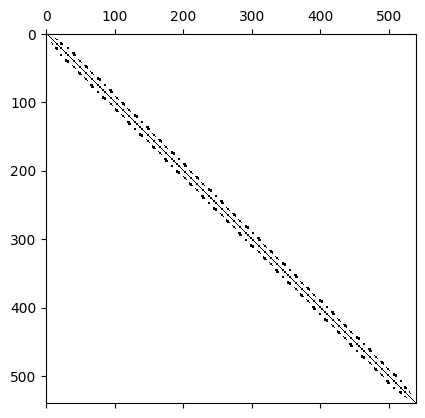

In [23]:
K_a = petsc2array(K)
C_1_a = petsc2array(C_1)

plt.spy(np.matmul(K_a , C_1_a ))

In [31]:
# Crear la matriz de PETSc de tamaño total
num_blocks = C_1_array.shape[0]
matrix_size = C_1_array.shape[1] * num_blocks
C_1 = PETSc.Mat().create()
C_1.setSizes([matrix_size, matrix_size])
C_1.setType(PETSc.Mat.Type.DENSE)
C_1.setUp()

# Asignar cada bloque en la diagonal
for i in range(num_blocks):
    start = i * dof_elem
    end = start + dof_elem
    C_1.setValues(range(start, end),range(start, end), C_1_array[i])

# Finalizar el ensamblaje de la matriz
C_1.assemble()

In [32]:
for  i in range(0,3):
    print(i)

0
1
2


error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


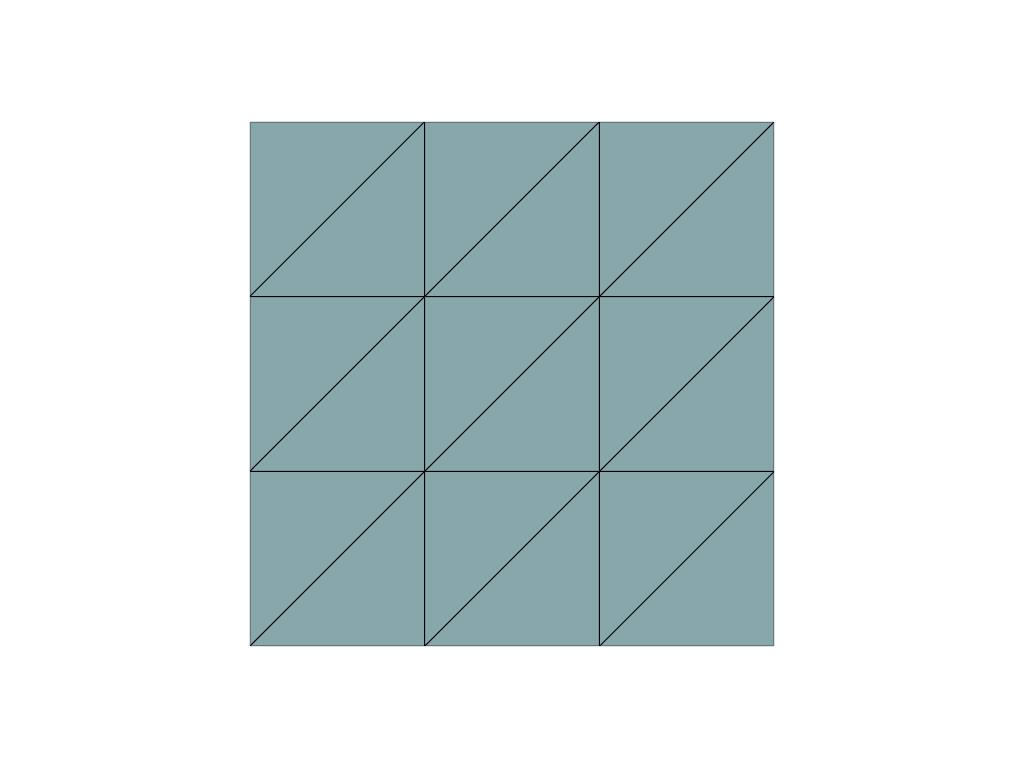

In [7]:
import pyvista 
pyvista.start_xvfb()
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.add_axes
plotter.show()


In [45]:


A = assemble_matrix(a, bcs=[bc])
A.assemble()
b = create_vector(L)

solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

t = 0

uh = fem.Function(V)
uh.name = "u"
uh.interpolate(u_a.eval)
u_file = io.VTKFile(mesh.comm, "resultsdx/u.pvd","w")
u_file.write_mesh(mesh)

tol = 0.001  # Avoid hitting the outside of the domain
x = np.linspace(start + tol, x_end - tol, 101)
points = np.zeros((3, 101))
points[0] = x
points[1] = np.full(101, 0.5)
bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
for n_s in range(num_steps):
    # Update Diriclet boundary condition
    t += dt
    print (f'time : {t} step : {n_s}' )
    u_a.t += dt
    u_bc.interpolate(u_a.eval )

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, L)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [a], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_nnn.x.array[:] = u_nn.x.array
    u_nn.x.array[:] = u_n.x.array
    u_n.x.array[:] = uh.x.array
    if n_s%10 == 0 :
        u_file.write_function(uh,t)
    
        #plot
        u_values = []
        p_values = []
        
        u_values = uh.eval(points_on_proc, cells)
        import matplotlib.pyplot as plt
        fig = plt.figure()
        plt.plot(points_on_proc[:, 0], u_values, "k", linewidth=2, label="u value")
        plt.grid(True)
        plt.xlabel("x")
        plt.legend()
        plt.xlim(0,10)
        plt.ylim(0,1)
        plt.show()


NameError: name 'F' is not defined